In [1]:
from synet.process.delay import simulate_delay, DelayProcess
from synet.generators import create_temporal_network
from synet.propagators.paint import paint_entropy
from synet.propagators.paths import path_entropy
from synet.propagators.mixing import mixing_entropy
from synet.analysis import entropy_dt

from collections import defaultdict
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import spearmanr


In [9]:
p_delay = 0.033
all_p_delay = [0, 0.01, 0.02, 0.03, 0.04, 0.05]
all_n_agents = [20, 40, 60, 120]
n_agents = 40
n_intern = 101
p_intern = 0
#all_p_intern = np.arange(n_intern)/(n_intern-1)
n_events = 10000
n_sample = 10
max_dt = 200


In [10]:
all_jobs = []
for n_agents in all_n_agents:
    A, event_list, participants = create_temporal_network(
    part_per_community=n_agents//2, p_intern=p_intern, n_events=n_events)
    for p_delay in all_p_delay:
        for i_sample in range(n_sample):
            job = {
                "class": DelayProcess,
                "args": [],
                "kwargs": {"p_delay": p_delay},
                "sim_args": (participants, 1, n_events, n_agents),
            }
            all_jobs.append(job)

In [11]:
results = DelayProcess.run_jobs(all_jobs)

In [12]:
plot_results = {}
for n_agents in all_n_agents:
    plot_results[n_agents] = np.zeros(len(all_p_delay))

for res in results:
    cur_result = np.mean(res[1])
    n_agents = res[0]["sim_args"][3]
    p_delay = res[0]["kwargs"]["p_delay"]
    i_p_delay = all_p_delay.index(p_delay)
    plot_results[n_agents][i_p_delay] += cur_result/n_sample

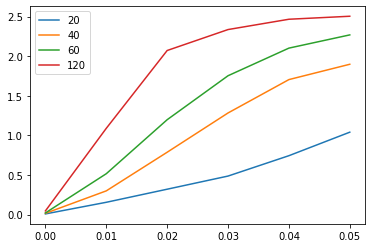

In [13]:
for n_agents, res in plot_results.items():
    plt.plot(all_p_delay, res, label=n_agents)
plt.legend()
plt.show()

In [ ]:
methods = {
    "paint": paint_entropy,
    "path": path_entropy,
    "mix": mixing_entropy,
}


In [ ]:
all_entropy_results = defaultdict(lambda: [])
all_disease_results = []

for p_intern in all_p_intern:
    A, event_list, participants = create_temporal_network(part_per_community=n_agents//2, p_intern=p_intern,
                                                          n_events=n_events)
    for method_name, method_fn in methods.items():
        res_dt = entropy_dt(A, max_dt=max_dt, entropy_game=method_fn)
        all_entropy_results[method_name].append(np.sum(res_dt))

    cur_results = np.zeros(n_events//2)
    for _ in range(n_sample):
        start = 1+np.random.randint(n_events//2-1)
        end = start + n_events//2
        cur_results += simulate_disease(participants, start, end, n_agents=n_agents, p_infected=p_infected)
    cur_results /= n_sample*n_agents
    all_disease_results.append(np.sum(cur_results))   
    print(p_intern)


In [ ]:
for method_name, results in all_entropy_results.items():
    res = spearmanr(all_disease_results, results).correlation
    plt.plot(all_disease_results, results, label=f"{method_name} ({res})")
plt.legend()
plt.show()